# Brownian bridges

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr

import matplotlib.pyplot as plt
from flax import nnx

from neuralbridge.sdes.examples import BrownianSDE, BrownianBridgeSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedBridgeSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import train, load

## Brownian Bridges

In [6]:
rngs = nnx.Rngs(0)

sde = BrownianSDE(
    dim=1,
    params={
        "mu": jnp.array([1.0]),
        "sigma": jnp.array([[1.0]])
    }
)

# A standard Brownian motion as the auxiliary SDE
aux_sde = AuxiliarySDE(
    dim=1,
    coeffs={
        "T": 1.0,
        "beta": lambda t: jnp.array([0.0]),
        "B": lambda t: jnp.array([[0.0]]),
        "a_tilde_0": None,
        "a_tilde_T": jnp.array([[1.0]])
    }
)

x0 = jnp.array([0.0])   # start point
vT = jnp.array([0.0])   # observation point
n_steps = 500           # number of time steps
ts = jnp.linspace(0., 1., n_steps+1, endpoint=True)
epsilon = 1e-5          # observation noise

guided_sde = GuidedBridgeSDE(
    sde, aux_sde,
    obs_params={
        "vT": vT,
        "LT": jnp.eye(1),   # fully observed
        "SigmaT": epsilon**2 * jnp.eye(1)
    },
    ts=ts,
    eq_type="uLM",          # u, L, M formulation of BIF ODE
)

b_fn = guided_sde.b
sigma_fn = guided_sde.sigma
G_fn = guided_sde.G

nn_config = {
    "model_name": "MLPSmall",
    "input_dim": 1,
    "output_dim": 1,
    "hidden_dims": (10, 10, 10),
    "act_type": "lipswish",
    "rngs": rngs
}
           
neural_bridge = NeuralBridge(
    b_fn, sigma_fn, G_fn, nn_config
)

train_config = {
    "ckpt_dir": "../assets/ckpts/neural_bridge/brownian",
    "lr": 1e-3,
    "batch_size": 100,
    "n_iters": 5000,
    "patience": 10
}

In [7]:
losses = train(neural_bridge, x0, ts, train_config, rngs=rngs)

# or load the pretrained model
# load(neural_bridge, train_config["ckpt_dir"])

Step [  100 / 5000]: loss = 0.745105, Time elapsed: 1.215s
Step [  200 / 5000]: loss = 0.526903, Time elapsed: 2.177s
Step [  300 / 5000]: loss = 0.524141, Time elapsed: 3.136s
Step [  400 / 5000]: loss = 0.502542, Time elapsed: 4.099s
Step [  500 / 5000]: loss = 0.502122, Time elapsed: 5.064s
Step [  600 / 5000]: loss = 0.484899, Time elapsed: 6.027s
Step [  700 / 5000]: loss = 0.498484, Time elapsed: 6.984s
Step [  800 / 5000]: loss = 0.517556, Time elapsed: 7.967s
Step [  900 / 5000]: loss = 0.514416, Time elapsed: 8.966s
Step [ 1000 / 5000]: loss = 0.497779, Time elapsed: 9.924s
Step [ 1100 / 5000]: loss = 0.510722, Time elapsed: 10.880s
Step [ 1200 / 5000]: loss = 0.513217, Time elapsed: 11.843s
Step [ 1300 / 5000]: loss = 0.497342, Time elapsed: 12.804s
Step [ 1400 / 5000]: loss = 0.506429, Time elapsed: 13.763s
Step [ 1500 / 5000]: loss = 0.493280, Time elapsed: 14.722s
Early stopping triggered! No improvement for 10 evaluations
Best loss: 0.484899 at step 600
Training completed

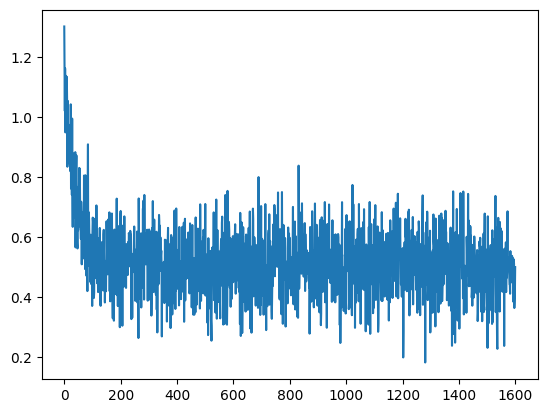

In [8]:
plt.plot(losses)

In [9]:
bridge_sde = BrownianBridgeSDE(
    dim=1,
    params={
        "mu": jnp.array([1.0]),
        "sigma": jnp.array([[1.0]]),
        "vT": vT,
        "T": 1.0
    }
)

In [10]:
neural_bridge.eval()
guided_solve = SDESolver(guided_sde)
nb_solve = SDESolver(neural_bridge)
bridge_solve = SDESolver(bridge_sde)

n_samples = 10

guided_traj = guided_solve.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)
nb_traj = nb_solve.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)
bridge_traj = bridge_solve.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)

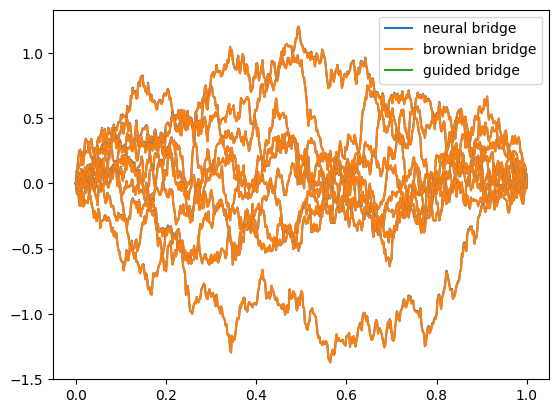

In [11]:
for i in range(n_samples):
    plt.plot(ts, nb_traj[i], color="tab:blue")
    plt.plot(ts, bridge_traj[i], color="tab:orange")
    # plt.plot(ts, guided_traj[i], color="tab:green")
    
plt.plot([], [], color="tab:blue", label="neural bridge")
plt.plot([], [], color="tab:orange", label="brownian bridge")
plt.plot([], [], color="tab:green", label="guided bridge")
plt.legend()
plt.show()